Plan:
1. get FEOBV HC vs Smokers difference map in MNI152 space
2. Parcellate the difference map using a DK atlas in MNI152 space
3. Select only left hemisphere of the parcellation

4. get gene expression scale033 data from Justine's paper
5. Convert expression data to DK atlas

6. Correlate FEOBV parcellation with gene expression using spin tests

In [115]:
# import numpy as np
import pandas as pd
import os
import nibabel as nb 
import numpy as np

import warnings 
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

from neuromaps.images import load_data, load_gifti, annot_to_gifti, relabel_gifti, construct_shape_gii
from neuromaps.datasets import fetch_annotation
from neuromaps.resampling import resample_images
from neuromaps.nulls import alexander_bloch, burt2020
from neuromaps.parcellate import Parcellater
from scipy.stats import pearsonr
from neuromaps import transforms 
from neuromaps.stats import compare_images
from neuromaps.nulls import hungarian

from surfplot import Plot
from neuromaps.datasets import fetch_fsaverage


In [116]:
# define working dir 
base_path = os.path.dirname(os.getcwd())

# create a object that will parcellate data into dk atlas
dk_mni = os.path.join(base_path, 'parcellations', 'atlas-desikankilliany_space-MNI_res-1mm.nii.gz')
parcellater_mni = Parcellater(dk_mni , 'MNI152')

In [117]:
# get FEOBV data 
smoking_pctdiff_file = os.path.join(base_path, 'data', 'smoking_pctdiff.nii.gz')

In [118]:
# parcellate FEOBV data 
smoking_parc = parcellater_mni.fit_transform(smoking_pctdiff_file, space='MNI152', ignore_background_data=True)

In [119]:
labels = pd.read_csv(os.path.join(base_path, 'parcellations','atlas-desikankilliany.csv') )
#labels['pctdiff'] = smoking_parc[0]
labels

,id,label,hemisphere,structure
0,1,bankssts,L,cortex
1,2,caudalanteriorcingulate,L,cortex
2,3,caudalmiddlefrontal,L,cortex
3,4,cuneus,L,cortex
4,5,entorhinal,L,cortex
...,...,...,...,...
78,79,pallidum,R,subcortex/brainstem
79,80,accumbensarea,R,subcortex/brainstem
80,81,hippocampus,R,subcortex/brainstem
81,82,amygdala,R,subcortex/brainstem


In [120]:
# read labels, add diff to dataframe and take only left cortex parcels 
labels = pd.read_csv(os.path.join(base_path, 'parcellations','atlas-desikankilliany.csv') )
labels['pctdiff'] = smoking_parc[0]
lh_labels = labels[(labels['hemisphere'] == 'L') & (labels['structure'] == 'cortex')]
lh_labels

,id,label,hemisphere,structure,pctdiff
0,1,bankssts,L,cortex,5.062069
1,2,caudalanteriorcingulate,L,cortex,1.545742
2,3,caudalmiddlefrontal,L,cortex,5.585381
3,4,cuneus,L,cortex,7.520157
4,5,entorhinal,L,cortex,-0.441212
...,...,...,...,...,...
29,30,supramarginal,L,cortex,6.485913
30,31,frontalpole,L,cortex,8.069247
31,32,temporalpole,L,cortex,0.514508
32,33,transversetemporal,L,cortex,4.535362


In [121]:
# do some stuff for plotting  
def get_labels(annot):
    aparc = os.path.join(os.environ['SUBJECTS_DIR'], 'fsaverage', 'label', annot)
    labels, ctab , names = nb.freesurfer.read_annot(aparc)
    labels = [i-1 if i>3 else i for i in labels] # good lord
    return(labels)

lh_parcelindex = get_labels('lh.aparc.annot')    
#rh_labels = get_labels('rh.aparc.annot')  
#lh_dk_parcelnames 


lh_labels.index = range(1, len(lh_labels) + 1)
pctdiff_dict= lh_labels['pctdiff'].to_dict()
#pctdiff_dict.update([(0,0), (-1,0)])
  #partial_r_dict.update([(0,0), (-1,0)])
pctdiff_dict
map = np.array([pctdiff_dict.get(index) for index in lh_parcelindex])

In [122]:
map.shape 

(163842,)

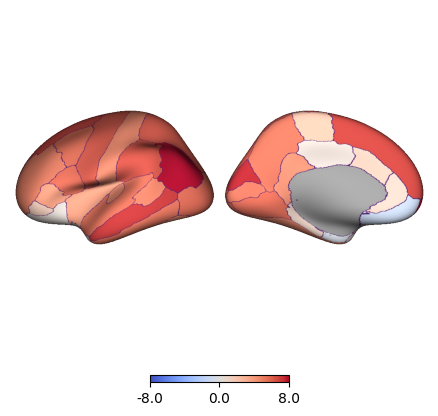

In [125]:
surface = fetch_fsaverage(density='164k')
lh, _ = surface['inflated']
dk = {'left': np.array(lh_parcelindex)}

# plot
p = Plot(lh, None, views=['lateral','medial'], zoom=1.2)
p.add_layer(map, cmap='coolwarm',color_range=(-8,8), cbar=True,zero_transparent=True  )
p.add_layer(dk, as_outline=True, cbar=False)
pic = p.build()

In [81]:
# load mrna
mrna = pd.read_csv(base_path + '/data/abagen_gexpression_desikankilliany.csv')
nicot = ['CHRNA1', 'CHRNA2','CHRNA3','CHRNA4','CHRNA5','CHRNA6','CHRNA7','CHRNA8','CHRNA9','CHRNA10', 'CHRNB1', 'CHRNB2', 'CHRNB3', 'CHRNB4' ]

df = pd.read_csv(os.path.join(base_path, 'parcellations','atlas-desikankilliany.csv') )

for i in nicot: 
    if i in mrna:
        df[i] = mrna[i]

df = df[(df['hemisphere'] == 'L') & (df['structure'] == 'cortex')]
df


,id,label,hemisphere,structure,CHRNA2,CHRNA3,CHRNA4,CHRNA6,CHRNA7,CHRNA10,CHRNB1,CHRNB2
0,1,bankssts,L,cortex,0.520447,0.182759,0.473688,0.360197,0.504364,0.579978,0.477933,0.399899
1,2,caudalanteriorcingulate,L,cortex,0.280811,0.358020,0.597791,0.451774,0.367192,0.455527,0.626538,0.474249
2,3,caudalmiddlefrontal,L,cortex,0.501028,0.204406,0.552763,0.582102,0.546924,0.555040,0.554942,0.428356
3,4,cuneus,L,cortex,0.629842,0.243255,0.370473,0.495418,0.487041,0.591772,0.347730,0.407543
4,5,entorhinal,L,cortex,0.191250,0.749880,0.548887,0.322963,0.456864,0.382501,0.641003,0.538481
...,...,...,...,...,...,...,...,...,...,...,...,...
29,30,supramarginal,L,cortex,0.460687,0.129123,0.514821,0.317568,0.500329,0.528419,0.436231,0.421340
30,31,frontalpole,L,cortex,0.644633,0.281611,0.385042,0.568162,0.525991,0.515297,0.683505,0.519821
31,32,temporalpole,L,cortex,0.340418,0.403676,0.494944,0.441497,0.549185,0.396433,0.706466,0.565612
32,33,transversetemporal,L,cortex,0.535778,0.176928,0.403662,0.427886,0.497550,0.625383,0.442391,0.441069


In [49]:
# correlate! alpha 4, alpha 7 & Beta 2 are the most common and interesting 
spins = pd.read_csv(os.path.join(base_path, 'parcellations','spins_hungarian_aparc+aseg_ctx.csv'), header=None)
spins.loc[0:33,]

,0,1,2,3,4,5,6,...,9993,9994,9995,9996,9997,9998,9999
0,17.0,13.0,33.0,7.0,24.0,21.0,12.0,...,17.0,7.0,31.0,24.0,6.0,13.0,7.0
1,15.0,22.0,23.0,25.0,18.0,32.0,19.0,...,20.0,18.0,5.0,19.0,2.0,4.0,19.0
2,10.0,28.0,1.0,26.0,8.0,17.0,32.0,...,31.0,25.0,32.0,1.0,29.0,12.0,13.0
3,5.0,30.0,21.0,29.0,19.0,11.0,23.0,...,3.0,29.0,10.0,29.0,22.0,3.0,29.0
4,18.0,19.0,29.0,8.0,2.0,13.0,7.0,...,28.0,6.0,4.0,8.0,4.0,23.0,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29,23.0,0.0,7.0,30.0,10.0,7.0,3.0,...,18.0,22.0,26.0,16.0,32.0,32.0,3.0
30,30.0,1.0,13.0,33.0,7.0,23.0,15.0,...,26.0,33.0,13.0,3.0,8.0,30.0,33.0
31,20.0,4.0,28.0,2.0,32.0,8.0,31.0,...,10.0,2.0,0.0,2.0,26.0,6.0,27.0
32,16.0,6.0,12.0,28.0,25.0,12.0,2.0,...,8.0,16.0,2.0,7.0,31.0,29.0,16.0


In [109]:
# do enigma map and turku map correlate?
FEOBV_delta = lh_labels['pctdiff'].to_numpy()
dk_fsaverage_164k = (os.path.join(base_path, 'parcellations', 'atlas-desikankilliany_space-fsaverage_den-164k_hemi-L.aparc-1.annot'))

dk_fsaverage_164k = annot_to_gifti(dk_fsaverage_164k)  # this does relabel_gift and also converts the annot file to gifti

# get spins 
spins = pd.read_csv(os.path.join(base_path, 'parcellations','spins_hungarian_aparc+aseg_ctx.csv'), header=None) # let's double check this if this is kosher
spins = spins.loc[0:33,]
nspins = spins.values.shape[1]

# get 10k rotations 
rotated = hungarian(data=FEOBV_delta, n_perm=10000, spins=spins, parcellation=dk_fsaverage_164k) 

res = pd.DataFrame(columns=['mrna', 'rho', 'pspin'])

for R in ['CHRNA2',	'CHRNA3','CHRNA4','CHRNA6','CHRNA7','CHRNA10','CHRNB1','CHRNB2']:
    expression = df[R].to_numpy()
    rho, p = pearsonr(expression , FEOBV_delta)
    
    # get null
    n = np.zeros((nspins, ))
    for i in range(nspins):
        n[i] = pearsonr(expression, rotated[:,i])[0]    
    
    # get p-value
    pspin = (1 + sum(abs(n) > abs(rho ))) / (nspins + 1)
    row_to_add = pd.Series({'mrna': R, 'rho': rho, 'pspin': pspin })
    res = pd.concat([res, row_to_add.to_frame().T], ignore_index=True)
    print(rho, pspin)

0.5881286133831463 0.0004999500049995
-0.5074725222547694 0.0020997900209979003
-0.18503363486920812 0.300969903009699
-0.04406001304447615 0.8014198580141986
0.10513647763659481 0.5211478852114788
0.3638033057229126 0.036696330366963306
-0.4001586035775393 0.021397860213978603
-0.4489479787114088 0.013898610138986101


Text(0, 0.5, 'CHRNA2 expression levels')

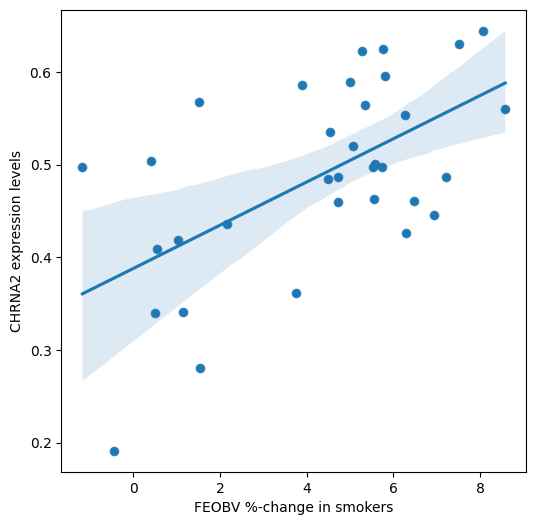

In [110]:
import seaborn as sns
import matplotlib.pyplot  as plt
df_plotting = pd.DataFrame({'FEOBV': FEOBV_delta, 'CHRNA2' : df['CHRNA2'].to_numpy() })
df_plotting
fig, ax = plt.subplots(figsize=(6,6))
sns.scatterplot(data=df_plotting, x='FEOBV', y='CHRNA2' )
sns.regplot(data=df_plotting, x='FEOBV', y='CHRNA2' )
ax.set_xlabel('FEOBV %-change in smokers')
ax.set_ylabel('CHRNA2 expression levels')

Text(0, 0.5, 'CHRNA3 expression levels')

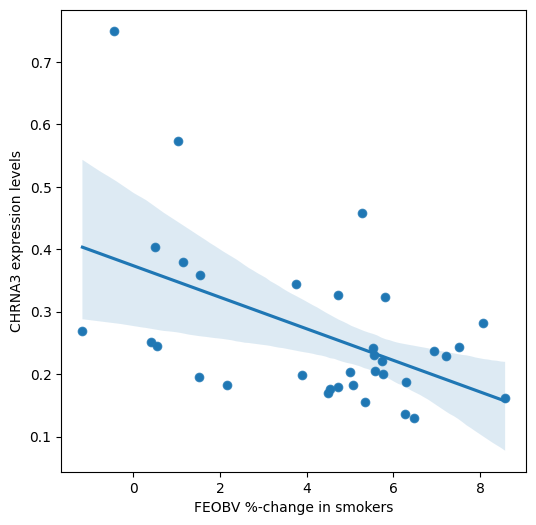

In [111]:
df_plotting = pd.DataFrame({'FEOBV': FEOBV_delta, 'CHRNA3' : df['CHRNA3'].to_numpy() })
df_plotting['label'] = df['label']
fig, ax = plt.subplots(figsize=(6,6))
sns.scatterplot(data=df_plotting, x='FEOBV', y='CHRNA3' )
sns.regplot(data=df_plotting, x='FEOBV', y='CHRNA3' )
ax.set_xlabel('FEOBV %-change in smokers')
ax.set_ylabel('CHRNA3 expression levels')
#plt.text(data['FEOBV'][i], data['y'][i], data['label'][i], 
#             fontsize=9, ha='right')

In [112]:
max_value = np.max(df_plotting['CHRNA3'])
print(df_plotting[df_plotting['CHRNA3'] == max_value])


min_value = np.min(df_plotting['CHRNA3'])
print(df_plotting[df_plotting['CHRNA3'] == min_value])

      FEOBV   CHRNA3       label
4 -0.441212  0.74988  entorhinal
       FEOBV    CHRNA3          label
29  6.485913  0.129123  supramarginal


In [113]:
res

,mrna,rho,pspin
0,CHRNA2,0.588129,0.0005
1,CHRNA3,-0.507473,0.0021
2,CHRNA4,-0.185034,0.30097
3,CHRNA6,-0.04406,0.80142
4,CHRNA7,0.105136,0.521148
5,CHRNA10,0.363803,0.036696
6,CHRNB1,-0.400159,0.021398
7,CHRNB2,-0.448948,0.013899
